# Estimation of misspecification errors

We estimate interpolation errors of the type
$$
\int_{\Omega} \mathbb{E} (y(x) - \hat{y}(x))^2 dx,
$$
where $y(x)$ is a realization of Gaussian process in $\mathbb{R}^d$, and $\hat{y}(x)$ is an interpolation created on the base of Gaussian process regression model and given sample, $\Omega$ is our domain of interest e.g. $[0, h]^d$.

In [3]:
# import main packages
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pylab

% matplotlib inline

In [6]:
# set parameters for matplotlib
from matplotlib import rcParams

pylab.rcParams['figure.figsize'] = (10.0, 8.0)
pylab.rcParams['font.size'] = "14"

from matplotlib import rc
rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})


In [7]:
# import Gaussian process regression and utility packages. See utility.py in the folder
import GPy
import utility
import importlib
utility = importlib.reload(utility)

## Example comparison of predictions using a wrong kernel function

In [8]:
# get realization of Gaussian proess with desired covariance function

# generate input points
step_size = 1 / 1000.
sample_size = int(1 / step_size) # sample size for x in [0, 1]
points = np.linspace(0, 1, sample_size).reshape(-1, 1) # one dimensional points column of desired size

# generate target values
true_theta = 0.1 # true parameter for covariance function
covariance_matrix = utility.get_covariance_matern_12(points, {'theta' : true_theta, 'noise_variance' : 1e-16}) 
cholesky_covariance = np.linalg.cholesky(covariance_matrix)
values = np.random.randn(sample_size, 1)
values = np.dot(cholesky_covariance, values)

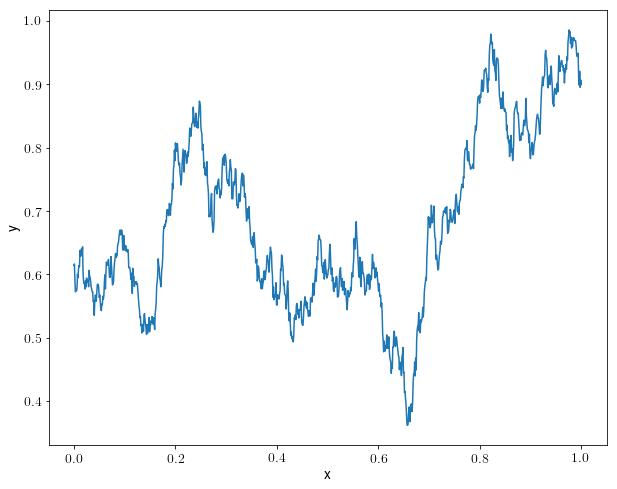

In [9]:
# plot obtained realization
plt.plot(points, values)
plt.xlabel(r"x")
plt.ylabel(r"y")

In [10]:
# downsample training sample
training_points = points[::10, :]
training_values = values[::10]
print(np.shape(training_points))

(100, 1)


In [11]:
# get another exponential kernel
variance = np.sqrt(np.pi / 2.)
theta_estimate = 0.3
kernel = GPy.kern.Exponential(input_dim=1, variance=variance, lengthscale=1. / theta_estimate**0.5)
noise_variance = 1e-8

# create Gaussian process regression model with specified kernel
gp_model = GPy.models.GPRegression(training_points, training_values.reshape(-1, 1), kernel)
gp_model.Gaussian_noise.fix(noise_variance)

# predict values for all given points
predicted_values, predicted_variances = gp_model.predict(points)

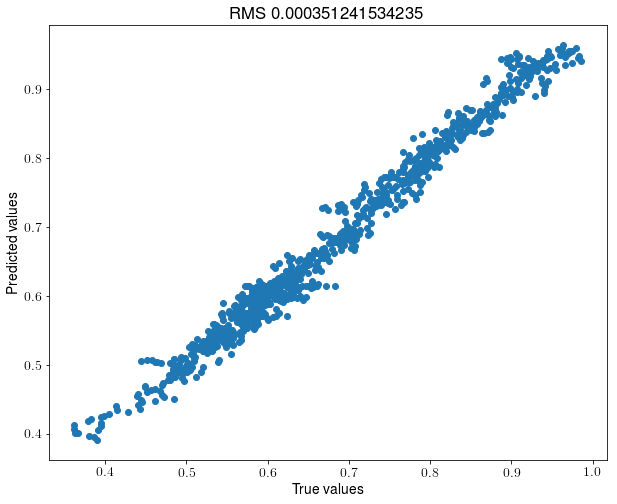

In [12]:
# plot predictions
plt.plot(values, predicted_values, 'o')
plt.title('RMS %s' % np.mean((predicted_values - values) ** 2))
plt.xlabel('True values')
plt.ylabel('Predicted values')

## Compare true errors and errors obtained using different covariance function parameter using exponential covariance function

In [ ]:
# set sample size
sample_size_number = 31
sample_size_array = np.array([int(x) for x in np.linspace(1000, 3000, sample_size_number)])
coefficient = 10 # downsampling for step size
step_size_array = 1. / sample_size_array * coefficient 

In [34]:
def get_error_value(true_covariance, used_covariance, training_sample_size, test_sample_size=999):
    """ Get MSE error for uniform test sample
    """
    training_points = np.linspace(0, 1, training_sample_size).reshape(-1, 1)
    training_points = training_points + 1e-3 # shift to avoid ill-defined covariance matrix
    test_points = np.linspace(0, 1, test_sample_size).reshape(-1, 1)  
    
    # generate values
    points = np.vstack((training_points, test_points))
    sample_size = training_sample_size + test_sample_size
    covariance_matrix = true_covariance.K(points, points)
    values = np.random.multivariate_normal(np.zeros((sample_size, )), covariance_matrix, 1).reshape(-1, 1)
        
    # generate training points
    training_points = points[:training_sample_size, :]
    training_values = values[:training_sample_size].reshape(-1, 1)
    
    test_points = points[training_sample_size:, :]
    test_values = values[training_sample_size:]
    
    # generate an alternative kernel which in this case coincides with the true one
    noise_variance = 1e-8
    
    # create model using training data
    gp_model = GPy.models.GPRegression(training_points, training_values, 
                                       used_covariance)
    gp_model.Gaussian_noise.fix(noise_variance)
    
    # get predictions
    predicted_values, predicted_variances = gp_model.predict(test_points)
    
    # get errors for given sample size
    mse_error = np.mean((predicted_values - test_values) ** 2) 
    return mse_error

In [38]:
variance = np.sqrt(np.pi / 2.)
true_theta = 0.3
true_covariance = GPy.kern.Exponential(input_dim=1, variance=variance, lengthscale=1. / true_theta**0.5)

variance = np.sqrt(np.pi / 2.)
theta_estimate = 0.3
first_used_covariance = GPy.kern.Exponential(input_dim=1, variance=variance, lengthscale=1. / theta_estimate**0.5)

theta_estimate = 0.1
second_used_covariance = GPy.kern.Exponential(input_dim=1, variance=variance, lengthscale=1. / theta_estimate**0.5)

theta_estimate = 1
third_used_covariance = GPy.kern.Exponential(input_dim=1, variance=variance, lengthscale=1. / theta_estimate**0.5)

first_error_array = np.zeros((sample_size_number, 1))
for index, sample_size in enumerate(sample_size_array):
    first_error_array[index] = get_error_value(true_covariance, first_used_covariance, sample_size)

second_error_array = np.zeros((sample_size_number, 1))
for index, sample_size in enumerate(sample_size_array):
    second_error_array[index] = get_error_value(true_covariance, second_used_covariance, sample_size)
    
third_error_array = np.zeros((sample_size_number, 1))
for index, sample_size in enumerate(sample_size_array):
    third_error_array[index] = get_error_value(true_covariance, third_used_covariance, sample_size)

 C:\Users\User\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning:covariance is not positive-semidefinite.


KeyboardInterrupt: 

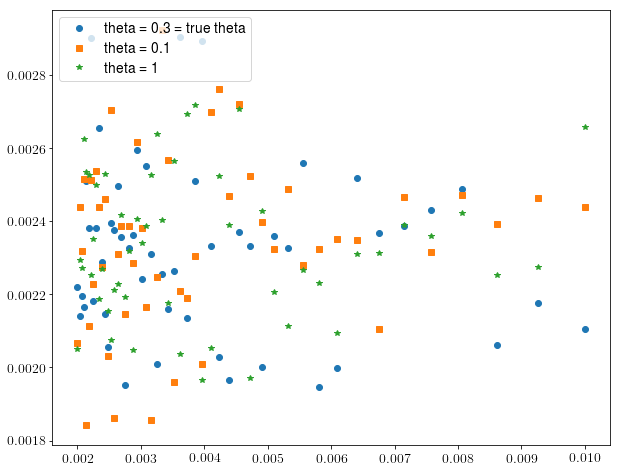

In [37]:
plt.plot(step_size_array, first_error_array, 'o', label='theta = 0.3 = true theta')
plt.plot(step_size_array, second_error_array, 's', label='theta = 0.1')
plt.plot(step_size_array, third_error_array, '*', label='theta = 1')
plt.legend(loc='upper left')

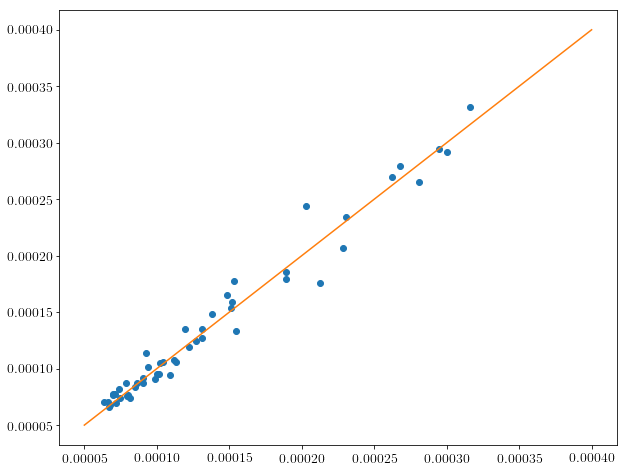

In [18]:
plt.plot(error_array_true, error_array, 'o')
plt.plot([0.00005, 0.00040], [0.00005, 0.00040])

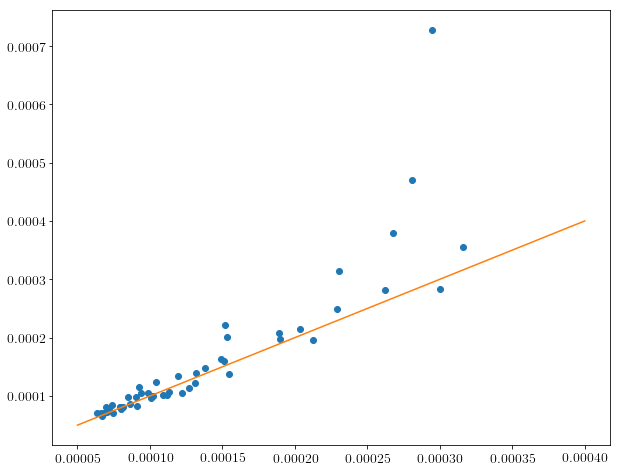

In [19]:
plt.plot(error_array_true, error_array_second, 'o')
plt.plot([0.00005, 0.00040], [0.00005, 0.00040])

In [83]:
sample_size_array = np.array([int(x) for x in np.linspace(1000, 3000, 31)])
coefficient = 10
h_array = 1. / sample_size_array * coefficient

variance = 1 # np.sqrt(np.pi / 2.)
noise_variance = 1e-8

first_error_array = np.zeros((sample_size_array.shape[0], 1))
for index, sample_size in enumerate(sample_size_array):
    points = np.linspace(0, 1, sample_size).reshape(-1, 1)
    true_theta = 0.1
    covariance_matrix = (np.pi / 2) ** 0.5 * utility.get_covariance_matern_12(points, {'theta' : true_theta, 'noise_variance' : 1e-16})
    cholesky_covariance = np.linalg.cholesky(covariance_matrix)
    values = np.random.randn(sample_size, 1)
    values = np.dot(cholesky_covariance, values)

    training_points = points[::coefficient, :]
    training_values = values[::coefficient]

    theta_estimate = true_theta
    kernel = GPy.kern.Exponential(input_dim=1, variance=variance, lengthscale=1. / theta_estimate**0.5)

    gp_model = GPy.models.GPRegression(training_points, training_values.reshape(-1, 1), kernel)
    gp_model.Gaussian_noise.fix(noise_variance)
    predicted_values, predicted_variances = gp_model.predict(points)
    first_error_array[index] = np.sum((predicted_values - values) ** 2 * (points[1, 0] - points[0, 0]))
    print first_error_array[index]
    
second_error_array = np.zeros((sample_size_array.shape[0], 1))
for index, sample_size in enumerate(sample_size_array):
    points = np.linspace(0, 1, sample_size).reshape(-1, 1)
    true_theta = 0.2
    covariance_matrix = (np.pi / 2) ** 0.5 * utility.get_covariance_matern_12(points, {'theta' : true_theta, 'noise_variance' : 1e-16})
    cholesky_covariance = np.linalg.cholesky(covariance_matrix)
    values = np.random.randn(sample_size, 1)
    values = np.dot(cholesky_covariance, values)

    training_points = points[::coefficient, :]
    training_values = values[::coefficient]

    theta_estimate = true_theta
    kernel = GPy.kern.Exponential(input_dim=1, variance=variance, lengthscale=1. / theta_estimate**0.5)

    gp_model = GPy.models.GPRegression(training_points, training_values.reshape(-1, 1), kernel)
    gp_model.Gaussian_noise.fix(noise_variance)
    predicted_values, predicted_variances = gp_model.predict(points)
    second_error_array[index] = np.sum((predicted_values - values) ** 2 * (points[1, 0] - points[0, 0]))
    print second_error_array[index]
    
third_error_array = np.zeros((sample_size_array.shape[0], 1))
for index, sample_size in enumerate(sample_size_array):
    points = np.linspace(0, 1, sample_size).reshape(-1, 1)
    true_theta = 0.3
    covariance_matrix = (np.pi / 2) ** 0.5 * utility.get_covariance_matern_12(points, {'theta' : true_theta, 'noise_variance' : 1e-16})
    cholesky_covariance = np.linalg.cholesky(covariance_matrix)
    values = np.random.randn(sample_size, 1)
    values = np.dot(cholesky_covariance, values)

    training_points = points[::coefficient, :]
    training_values = values[::coefficient]
    
    theta_estimate = true_theta
    kernel = GPy.kern.Exponential(input_dim=1, variance=variance, lengthscale=1. / theta_estimate**0.5)

    gp_model = GPy.models.GPRegression(training_points, training_values.reshape(-1, 1), kernel)
    gp_model.Gaussian_noise.fix(noise_variance)
    
    predicted_values, predicted_variances = gp_model.predict(points)
    third_error_array[index] = np.sum((predicted_values - values) ** 2 * (points[1, 0] - points[0, 0]))
    print third_error_array[index]

[ 0.00042522]
[ 0.00036913]
[ 0.00042243]
[ 0.00033816]
[ 0.0003215]
[ 0.00030735]
[ 0.00028498]
[ 0.00027927]
[ 0.00024291]
[ 0.00025473]
[ 0.00025799]
[ 0.00023375]
[ 0.0002085]
[ 0.00023077]
[ 0.00021406]
[ 0.00020621]
[ 0.00019628]
[ 0.00019793]
[ 0.00018748]
[ 0.00019352]
[ 0.00017042]
[ 0.00017903]
[ 0.00014978]
[ 0.00016079]
[ 0.00015385]
[ 0.00016835]
[ 0.00014927]
[ 0.00014372]
[ 0.00013831]
[ 0.00013565]
[ 0.00012595]
[ 0.00088185]
[ 0.00080362]
[ 0.00087377]
[ 0.00061738]
[ 0.00067954]
[ 0.00058719]
[ 0.00055712]
[ 0.00056601]
[ 0.00050757]
[ 0.0004828]
[ 0.00047338]
[ 0.00046941]
[ 0.0004616]
[ 0.00040627]
[ 0.00041991]
[ 0.00040734]
[ 0.00040987]
[ 0.00035328]
[ 0.00039966]
[ 0.00039301]
[ 0.00038529]
[ 0.00036666]
[ 0.00037399]
[ 0.000349]
[ 0.00032144]
[ 0.00030229]
[ 0.00026378]
[ 0.00031355]
[ 0.00029575]
[ 0.00028596]
[ 0.00027216]
[ 0.0012312]
[ 0.00117922]
[ 0.00115124]
[ 0.00088896]
[ 0.00092214]
[ 0.00098438]
[ 0.00086682]
[ 0.00086259]
[ 0.00071786]
[ 0.00075164]

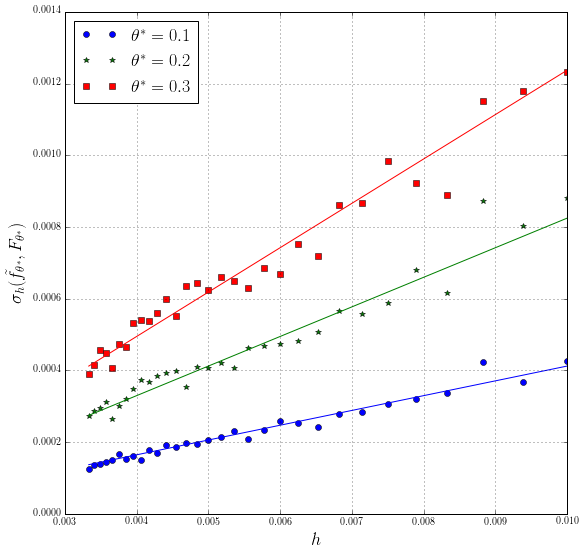

In [84]:
plt.figure(figsize=(9, 9))
scale_coefficient = 0.05 * np.sqrt(np.pi / 2)
plt.plot(h_array, first_error_array, 'o', label=r'$\theta^* = 0.1$')
plt.plot(h_array, second_error_array, '*', label=r'$\theta^* = 0.2$')
plt.plot(h_array, third_error_array, 's', label=r'$\theta^* = 0.3$')
plt.plot(h_array, 2 / 3. * np.pi ** 2 * 0.1 * h_array * scale_coefficient, 'b')
plt.plot(h_array, 2 / 3. * np.pi ** 2 * 0.2 * h_array * scale_coefficient, 'g')
plt.plot(h_array, 2 / 3. * np.pi ** 2 * 0.3 * h_array * scale_coefficient, 'r')
plt.legend(loc='upper left', fontsize=18)
plt.xlabel(r'$h$', fontsize=18)
plt.ylabel(r'$\sigma_h(\tilde{f}_{\theta^*}, F_{\theta^*})$', fontsize=18)
plt.grid(True)
plt.savefig('true_estimated_error.png', dpi=300)

In [85]:
print 1 / 500.
print training_points[1] - training_points[0]

0.002
[ 0.00333444]


In [6]:
sample_size_array = np.array([100, 500, 2000])
coefficient = 10
h_array = 1. / sample_size_array * coefficient
true_theta = 1

variance = 1 # np.sqrt(np.pi / 2.)
noise_variance = 1e-8

index_number = 20
errors_lists = []
for theta_estimate in [0.1, 1, 10]:
    for sample_size in sample_size_array:
        first_error_array = np.zeros((index_number, 1))
        for index in range(index_number):
            points = np.linspace(0, 1, sample_size).reshape(-1, 1)
            covariance_matrix = (np.pi / 2) ** 0.5 * utility.get_covariance_matern_12(points, 
                                                                                      {'theta' : true_theta, 'noise_variance' : 1e-16})
            cholesky_covariance = np.linalg.cholesky(covariance_matrix)
            values = np.random.randn(sample_size, 1)
            values = np.dot(cholesky_covariance, values)

            training_points = points[::coefficient, :]
            training_values = values[::coefficient]

            theta_estimate = 0.1
            kernel = GPy.kern.Exponential(input_dim=1, variance=variance, lengthscale=1. / theta_estimate**0.5)

            gp_model = GPy.models.GPRegression(training_points, training_values.reshape(-1, 1), kernel)
            gp_model.Gaussian_noise.fix(noise_variance)
            predicted_values, predicted_variances = gp_model.predict(points)
            first_error_array[index] = np.sum((predicted_values - values) ** 2 * (points[1, 0] - points[0, 0]))
        print([np.mean(first_error_array), np.std(first_error_array) / (index_number + 0.) ** 0.5])
        errors_lists.append(first_error_array)


[0.047551965220798999, 0.0036305546091712931]
[0.009170006658247163, 0.00028293694246753041]
[0.0020521140634938576, 2.3780067853836417e-05]
[0.050615955851527908, 0.0044381317478878867]
[0.0091015042380762599, 0.00020071584166218078]
[0.0020729121058605448, 3.672438254985894e-05]
[0.053432655545687935, 0.0029590883117142888]
[0.0083660752174230975, 0.00023510627902641033]
[0.0020431712457718095, 2.4287707353310331e-05]


In [5]:
import scipy

In [4]:
from sklearn import metrics

In [15]:
scipy.stats.ranksums(errors_lists[2], errors_lists[8])

RanksumsResult(statistic=0.43280142464036747, pvalue=0.66515903827637635)

In [19]:
sample_size_array = np.array([100, 500, 2000])
coefficient = 10
h_array = 1. / sample_size_array * coefficient
true_theta = 1

variance = 1 # np.sqrt(np.pi / 2.)
noise_variance = 1e-8

index_number = 20
errors_lists = []
for theta_estimate in [0.1, 1, 10]:
    for sample_size in sample_size_array:
        first_error_array = np.zeros((index_number, 1))
        for index in range(index_number):
            points = np.linspace(0, 1, sample_size).reshape(-1, 1)
            covariance_matrix = (np.pi / 2) ** 0.5 * utility.get_covariance_matern_32(points, 
                                                                                      {'theta' : true_theta, 'noise_variance' : 1e-16})
            cholesky_covariance = np.linalg.cholesky(covariance_matrix)
            values = np.random.randn(sample_size, 1)
            values = np.dot(cholesky_covariance, values)

            training_points = points[::coefficient, :]
            training_values = values[::coefficient]

            theta_estimate = 0.1
            kernel = GPy.kern.Matern32(input_dim=1, variance=variance, lengthscale=1. / theta_estimate**0.5)

            gp_model = GPy.models.GPRegression(training_points, training_values.reshape(-1, 1), kernel)
            gp_model.Gaussian_noise.fix(noise_variance)
            predicted_values, predicted_variances = gp_model.predict(points)
            first_error_array[index] = np.sum((predicted_values - values) ** 2 * (points[1, 0] - points[0, 0]))
        print([np.mean(first_error_array), np.std(first_error_array) / (index_number + 0.) ** 0.5])
        errors_lists.append(first_error_array)

[0.00030486970531211675, 6.7551347889546005e-05]
[1.5629633183486886e-06, 1.3019666057162068e-07]
[1.227308463299023e-07, 2.9920439641779724e-09]
[0.00038111270616461622, 6.0708655563080887e-05]
[1.8541070388204987e-06, 2.3371471307897173e-07]
[1.2441121407001251e-07, 3.9104775808627555e-09]
[0.00040077104919546163, 9.6888288298899685e-05]
[1.9916731123850199e-06, 2.1647037324946548e-07]
[1.1928959267323026e-07, 2.9688948386517408e-09]


In [21]:
for x in errors_lists:
    print([np.mean(x) * 1e6, np.std(x) * 1e6])

[304.86970531211676, 302.09881170552364]
[1.5629633183486886, 0.58225716696322094]
[0.1227308463299023, 0.013380827391139785]
[381.11270616461621, 271.49736132333931]
[1.8541070388204988, 1.04520397157288]
[0.12441121407001252, 0.017488187390596106]
[400.77104919546161, 433.29759771987432]
[1.99167311238502, 0.96808493940111373]
[0.11928959267323026, 0.013277301354547126]


## Squared exponential covariance function

In [51]:
def get_sample(sample_size, true_theta):
    points = np.linspace(0, 1, sample_size).reshape(-1, 1)
    covariance_matrix = (np.pi / 2) ** 0.5 * utility.get_covariance(points, {'theta' : true_theta, 'noise_variance' : 1e-16})
    cholesky_covariance = np.linalg.cholesky(covariance_matrix)
    values = np.random.randn(sample_size, 1)
    values = np.dot(cholesky_covariance, values)
    return points, values

def get_full_sample(first_sample_size, second_sample_size, true_theta):
    first_points = np.linspace(0, 1, first_sample_size).reshape(-1, 1)
    second_points = np.linspace(0, 1, second_sample_size).reshape(-1, 1)
    points = np.vstack((first_points, second_points))
    covariance_matrix = (np.pi / 2) ** 0.5 * utility.get_covariance(points, {'theta' : true_theta, 'noise_variance' : 1e-16})
    # covariance_matrix = (np.pi / 2) ** 0.5 * utility.get_covariance_matern_12(points, {'theta' : true_theta, 'noise_variance' : 1e-16})
    cholesky_covariance = np.linalg.cholesky(covariance_matrix)
    values = np.random.randn(first_sample_size + second_sample_size, 1)
    values = np.dot(cholesky_covariance, values).reshape(-1, 1)
    first_values = values[:first_sample_size, :]
    second_values = values[first_sample_size:, :]
    return first_points, second_points, first_values, second_values

def get_error(training_sample_size, test_sample_size, true_theta, theta_estimate, noise_variance=1e-15, variance=1):
    (training_points, test_points, 
     training_values, test_values) = get_full_sample(training_sample_size, test_sample_size, true_theta)
    # kernel = GPy.kern.Exponential(input_dim=1, variance=variance, lengthscale=1. / theta_estimate**0.5)
    kernel = GPy.kern.RBF(input_dim=1, variance=variance, lengthscale=1. / theta_estimate**0.5)

    gp_model = GPy.models.GPRegression(training_points, training_values.reshape(-1, 1), kernel)
    gp_model.Gaussian_noise.fix(noise_variance)
    predicted_values, predicted_variances = gp_model.predict(test_points)
    integral_error = np.mean((predicted_values - test_values) ** 2)
    return integral_error

In [83]:
sample_size_array = np.array([int(x) for x in np.linspace(5, 300, 20)])
h_array = 1. / sample_size_array

test_sample_size = 517
error_number = 10

first_error_array = np.zeros((sample_size_array.shape[0], 1))
first_std_error_array = np.zeros((sample_size_array.shape[0], 1))
for index, training_sample_size in enumerate(sample_size_array):
    true_theta = 0.1
    used_theta = true_theta
    error = []
    for internal_index in range(error_number):
        error.append(get_error(training_sample_size, test_sample_size, true_theta, used_theta))
    first_error_array[index] = np.mean(error) 
    first_std_error_array[index] = np.std(error)
    print first_error_array[index]
    
second_error_array = np.zeros((sample_size_array.shape[0], 1))
second_std_error_array = np.zeros((sample_size_array.shape[0], 1))
for index, training_sample_size in enumerate(sample_size_array):
    true_theta = 1
    used_theta = true_theta
    error = []
    for internal_index in range(error_number):
        error.append(get_error(training_sample_size, test_sample_size, true_theta, used_theta))
    second_error_array[index] = np.mean(error) 
    second_std_error_array[index] = np.std(error)
    print second_error_array[index]

third_error_array = np.zeros((sample_size_array.shape[0], 1))
third_std_error_array = np.zeros((sample_size_array.shape[0], 1))
for index, training_sample_size in enumerate(sample_size_array):
    true_theta = 10
    used_theta = true_theta
    error = []
    for internal_index in range(error_number):
        error.append(get_error(training_sample_size, test_sample_size, true_theta, used_theta))
    third_error_array[index] = np.mean(error) 
    third_std_error_array[index] = np.std(error)
    print third_error_array[index]

[  2.05166614e-08]
[  1.66830716e-08]
[  1.56181218e-08]
[  1.42093696e-08]
[  1.36771771e-08]
[  1.36017808e-08]
[  1.37862984e-08]
[  1.35365721e-08]
[  1.37108434e-08]
[  1.28579486e-08]
[  1.30951230e-08]
[  1.33105980e-08]
[  1.29331293e-08]
[  1.27066019e-08]
[  1.28834903e-08]
[  1.35613484e-08]
[  1.33324332e-08]
[  1.32450699e-08]
[  1.27927954e-08]
[  1.30991514e-08]
[  1.54614120e-06]
[  3.77222613e-08]
[  2.43672869e-08]
[  1.83494906e-08]
[  2.21987049e-08]
[  1.68869211e-08]
[  1.83030325e-08]
[  1.64512662e-08]
[  1.52655965e-08]
[  1.68899938e-08]
[  1.52839287e-08]
[  1.61489640e-08]
[  1.74983055e-08]
[  1.35997584e-08]
[  1.43910736e-08]
[  1.43826051e-08]
[  1.56270190e-08]
[  1.35780109e-08]
[  1.37219568e-08]
[  1.45096122e-08]
[ 0.02439878]
[  8.80618190e-07]
[  1.69571637e-07]
[  1.07864063e-07]
[  1.20186219e-07]
[  1.28269338e-07]
[  1.69874531e-07]
[  1.06133327e-07]
[  1.65681123e-07]
[  1.30639315e-07]
[  1.31004514e-07]
[  9.73633041e-08]
[  1.10510493e-07

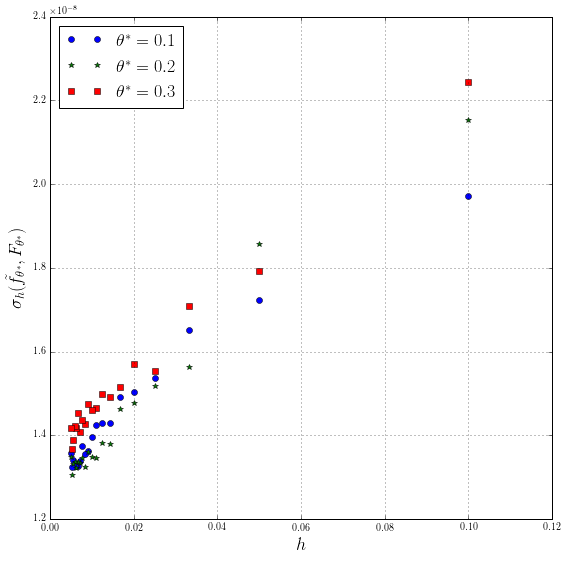

In [71]:
plt.figure(figsize=(9, 9))
scale_coefficient = 1e-7
plt.plot(h_array, first_error_array, 'o', label=r'$\theta^* = 0.1$')
plt.plot(h_array, second_error_array, '*', label=r'$\theta^* = 0.2$')
plt.plot(h_array, third_error_array, 's', label=r'$\theta^* = 0.3$')
# plt.plot(h_array, np.log(h_array) * scale_coefficient, 'b')
# plt.plot(h_array, 2 / 3. * np.pi ** 2 * 0.1 * h_array * scale_coefficient, 'b')
# plt.plot(h_array, 2 / 3. * np.pi ** 2 * 0.2 * h_array * scale_coefficient, 'g')
# plt.plot(h_array, 2 / 3. * np.pi ** 2 * 0.3 * h_array * scale_coefficient, 'r')
plt.legend(loc='upper left', fontsize=18)
plt.xlabel(r'$h$', fontsize=18)
plt.ylabel(r'$\sigma_h(\tilde{f}_{\theta^*}, F_{\theta^*})$', fontsize=18)
plt.grid(True)

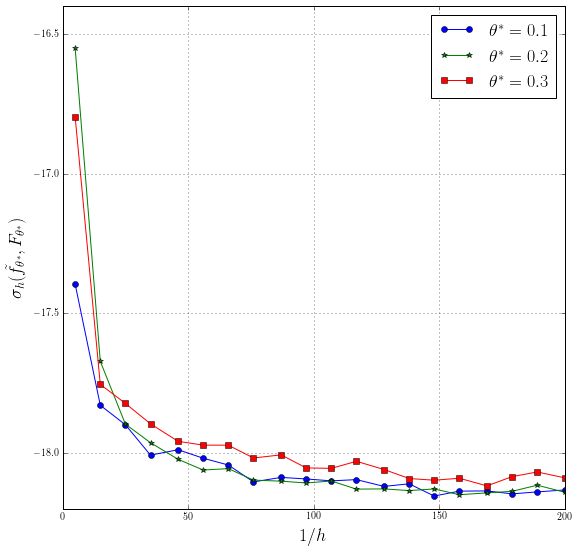

In [82]:
plt.figure(figsize=(9, 9))
scale_coefficient = 1e-7
plt.errorbar(1 / h_array, np.log(first_error_array), marker='o', label=r'$\theta^* = 0.1$')
plt.errorbar(1 / h_array, np.log(second_error_array), marker='*', label=r'$\theta^* = 0.2$')
plt.errorbar(1 / h_array, np.log(third_error_array), marker='s', label=r'$\theta^* = 0.3$')
# plt.plot(h_array, np.log(h_array) * scale_coefficient, 'b')
# plt.plot(h_array, 2 / 3. * np.pi ** 2 * 0.1 * h_array * scale_coefficient, 'b')
# plt.plot(h_array, 2 / 3. * np.pi ** 2 * 0.2 * h_array * scale_coefficient, 'g')
# plt.plot(h_array, 2 / 3. * np.pi ** 2 * 0.3 * h_array * scale_coefficient, 'r')
plt.legend(loc='upper right', fontsize=18)
plt.xlabel(r'$1 / h$', fontsize=18)
plt.ylabel(r'$\sigma_h(\tilde{f}_{\theta^*}, F_{\theta^*})$', fontsize=18)
plt.grid(True)